Tutorial 2: Data
================

In the previous tutorial, we used light profiles to create images of galaxies. However, those images don't accurately
represent what we would observe through a telescope.

Real telescope images, like those taken with the Charge Coupled Device (CCD) imaging detectors on the Hubble Space
Telescope (HST), include several factors that affect what we see:

**Telescope Optics:** The optical components of the telescope can blur the light, influencing the image's sharpness.

**Exposure Time:** The time the detector collects light, affecting the clarity of the image. Longer exposure times
gather more light, improving the signal-to-noise ratio and creating a clearer image.

**Background Sky:** Light from a background sky, such as distant stars or zodiacal light, adds noise to the image.

In this tutorial, we'll simulate a galaxy image by applying these real-world effects to the light profiles and images
we created earlier.

Here is an overview of what we'll cover in this tutorial:

- **Optics Blurring:** Simulating how the telescope optics blur the galaxy's light, making the image appear blurred.
- **Poisson Noise:** Adding Poisson noise to the image, simulating the randomness in the photon-to-electron conversion process on the CCD.
- **Background Sky:** Adding a background sky to the image, simulating the light from the sky that adds noise to the image.
- **Simulator:** Using the `SimulatorImaging` object to simulate imaging data that includes all these effects.
- **Output:** Saving the simulated data to `.fits` files for use in future tutorials, where .fits is the standard image format used by astronomers.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import numpy as np
from os import path
import autogalaxy as ag
import autogalaxy.plot as aplt

C:\Users\Jammy\anaconda3\envs\PyAuto311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\Jammy\Code\PyAuto\BSc_Galaxies_Project
Working Directory has been set to `C:\Users\Jammy\Code\PyAuto\BSc_Galaxies_Project`


__Initial Setup__

To create our simulated galaxy image, we first need a 2D grid. This grid will represent the coordinate space over 
which we will simulate the galaxy's light distribution.

In [2]:
grid = ag.Grid2D.uniform(
    shape_native=(
        101,
        101,
    ),  # The dimensions of the grid, which here is 101 x 101 pixels.
    pixel_scales=0.1,  # The conversion factor between pixel units and arc-seconds.
)

Next, we define the properties of our galaxy. In this tutorial, we’ll represent the galaxy with a bulge using a 
Sersic light profile.

In the previous tutorial, the units of `intensity` were arbitrary. However, for this tutorial, where we simulate 
realistic imaging data, the intensity must have specific units. We’ll use units of electrons per second per pixel 
($e- pix^-1 s^-1$), which is standard for CCD imaging data.

In [3]:
galaxy = ag.Galaxy(
    redshift=0.5,
    bulge=ag.lp.Sersic(
        centre=(0.0, 0.0),
        ell_comps=(0.0, 0.111111),
        intensity=1.0,  # in units of e- pix^-1 s^-1
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

galaxies = ag.Galaxies(galaxies=[galaxy])

To visualize the galaxy’s image, which we will use as the starting point for the simulations, we use the following code:

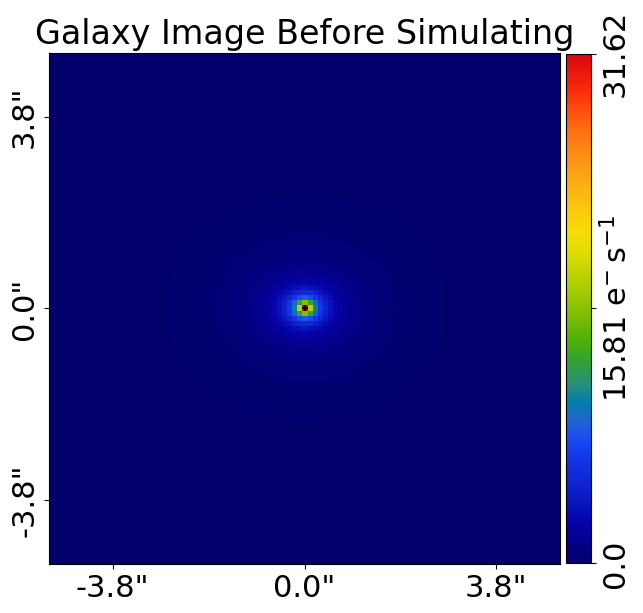

In [4]:
galaxies_plotter = aplt.GalaxiesPlotter(galaxies=galaxies, grid=grid)
galaxies_plotter.set_title("Galaxy Image Before Simulating")
galaxies_plotter.figures_2d(image=True)

__Optics Blurring__

All images captured using CCDs (like those on the Hubble Space Telescope) experience some level of blurring 
due to the optics of the telescope. This blurring occurs because the optical system spreads out the light from each 
point source (e.g., a star or a part of a galaxy).

The Point Spread Function (PSF) describes how the telescope blurs the image. It can be thought of as a 2D representation 
of how a single point of light would appear in the image, spread out by the optics. In practice, the PSF is a 2D 
convolution kernel that we apply to the image to simulate this blurring effect.

In [5]:
psf = ag.Kernel2D.from_gaussian(
    shape_native=(11, 11),  # The size of the PSF kernel, represented as an 11x11 grid.
    sigma=0.1,  # Controls the width of the Gaussian PSF, which determines the level of blurring.
    pixel_scales=grid.pixel_scales,  # Maintains consistency with the scale of the image grid.
    normalize=True,  # Normalizes the PSF kernel so that its values sum to 1.
)

We can visualize the PSF to better understand how it will blur the galaxy's image. The PSF is essentially a small 
image that represents the spreading out of light from a single point source. This kernel will be used to blur the 
entire galaxy image when we perform the convolution.

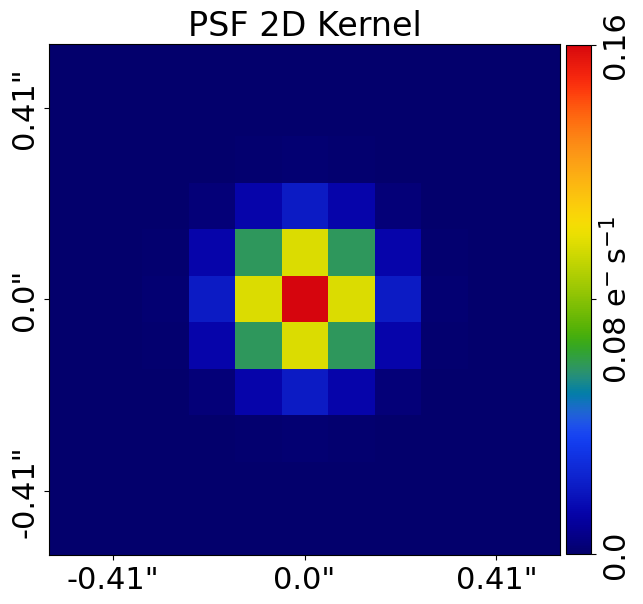

In [6]:
array_plotter = aplt.Array2DPlotter(array=psf)
array_plotter.set_title("PSF 2D Kernel")
array_plotter.figure_2d()

The PSF is often more informative when plotted on a log10 scale. This approach allows us to clearly observe values 
in its tail, which are much smaller than the central peak yet critical for many scientific analyses. The tail 
values may significantly affect the spread and detail captured in the data.

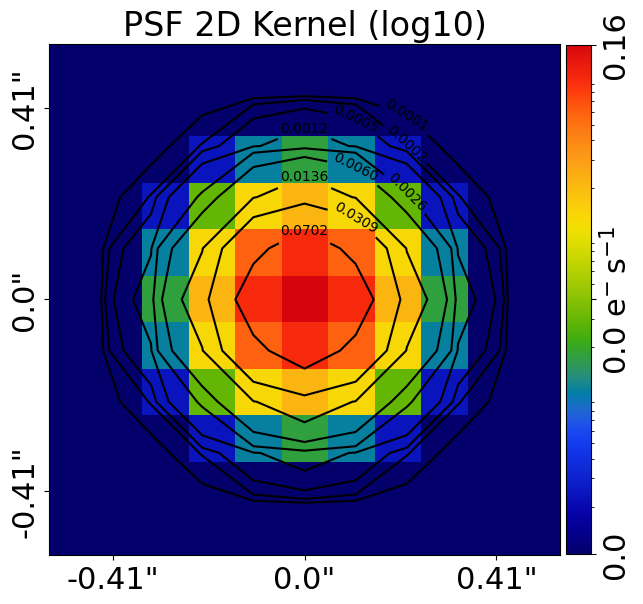

In [7]:
array_plotter = aplt.Array2DPlotter(array=psf, mat_plot_2d=aplt.MatPlot2D(use_log10=True))
array_plotter.set_title("PSF 2D Kernel")
array_plotter.figure_2d()

Next, we'll manually perform a 2D convolution of the PSF with the image of the galaxy. This convolution simulates the 
blurring that occurs when the telescope optics spread out the galaxy's light.

1. **Padding the Image**: Before convolution, we add padding (extra space with zero values) around the edges of the 
   image. This prevents unwanted edge effects when we perform the convolution, ensuring that the image's edges don't 
   become artificially altered by the process.

2. **Convolution**: Using the `Kernel2D` object's `convolve` method, we apply the 2D PSF convolution to the padded 
   image. This step combines the PSF with the galaxy's light, simulating how the telescope spreads out the light.

3. **Trimming the Image**: After convolution, we trim the padded areas back to their original size, obtaining a 
   convolved (blurred) image that matches the dimensions of the initial galaxy image.

In [8]:
image = galaxies.image_2d_from(grid=grid)  # The original unblurred image of the galaxy.
padded_image = galaxies.padded_image_2d_from(
    grid=grid, psf_shape_2d=psf.shape_native  # Adding padding based on the PSF size.
)
convolved_image = psf.convolved_array_from(
    array=padded_image
)  # Applying the PSF convolution.
blurred_image = convolved_image.trimmed_after_convolution_from(
    kernel_shape=psf.shape_native
)  # Trimming back to the original size.

We can now plot the original and the blurred images side by side. This allows us to clearly see how the PSF 
convolution affects the appearance of the galaxy, making the image appear softer and less sharp.

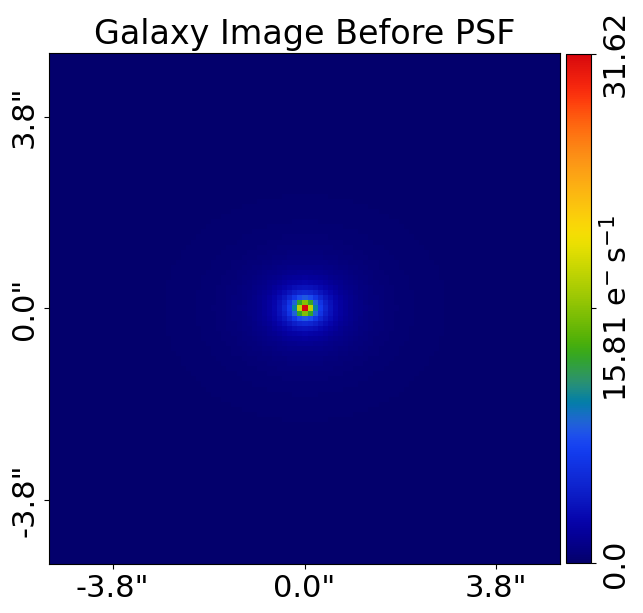

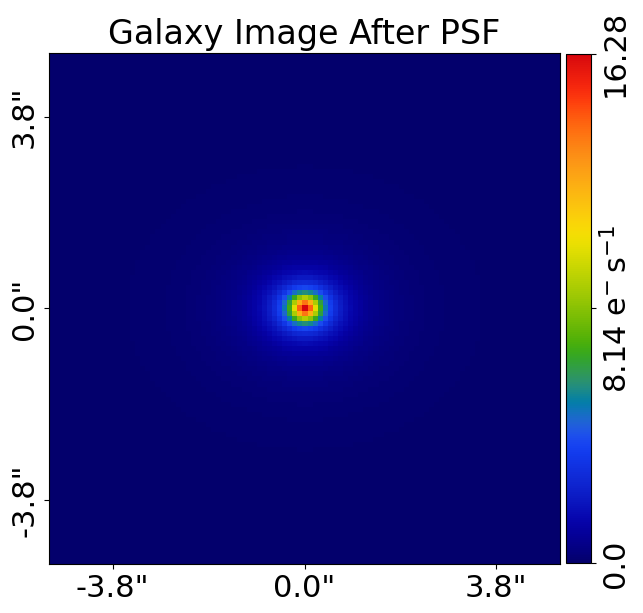

In [9]:
array_plotter = aplt.Array2DPlotter(array=image)
array_plotter.set_title("Galaxy Image Before PSF")
array_plotter.figure_2d()

array_plotter.set_title("Galaxy Image After PSF")
array_plotter = aplt.Array2DPlotter(array=blurred_image)
array_plotter.figure_2d()


__Poisson Noise__

In addition to the blurring caused by telescope optics, we also need to consider Poisson noise when simulating imaging 
data.

When a telescope captures an image of a galaxy, photons from the galaxy are collected by the telescope's mirror and 
directed onto a CCD (Charge-Coupled Device). The CCD is made up of a silicon lattice (or another material) that 
converts incoming photons into electrons. These electrons are then gathered into discrete squares, which form the 
pixels of the final image.

The process of converting photons into electrons is inherently random, following a Poisson distribution. This randomness 
means that the number of electrons in each pixel can vary, even if the same number of photons hits the CCD. Therefore, 
the electron count per pixel becomes a Poisson random variable. For our simulation, this means that the recorded 
number of photons in each pixel will differ slightly from the true number due to this randomness.

To replicate this effect in our simulation, we can add Poisson noise to the galaxy image using NumPy’s random module, 
which generates values from a Poisson distribution.

It's important to note that the blurring caused by the telescope optics occurs before the photons reach the CCD. 
Therefore, we need to add the Poisson noise after blurring the galaxy image.

We also need to consider the units of our image data. Let’s assume that the galaxy image is measured in units of 
electrons per second ($e^- s^{-1}$), which is standard for CCD imaging data. To simulate the number of electrons 
actually detected in each pixel, we multiply the image by the observation’s exposure time. This conversion changes t
he units to the total number of electrons collected per pixel over the entire exposure time.

Once the image is converted, we add Poisson noise, simulating the randomness in the photon-to-electron conversion 
process. After adding the noise, we convert the image back to units of electrons per second for analysis, as 
this is the preferred unit for astronomers when studying their data.

In [10]:
exposure_time = 300.0  # Units of seconds
blurred_image_counts = (
    blurred_image * exposure_time
)  # Convert to total electrons detected over the exposure time.
blurred_image_with_poisson_noise = (
    np.random.poisson(blurred_image_counts, blurred_image_counts.shape) / exposure_time
)  # Add Poisson noise and convert back to electrons per second.

Here is what the blurred image with Poisson noise looks like.

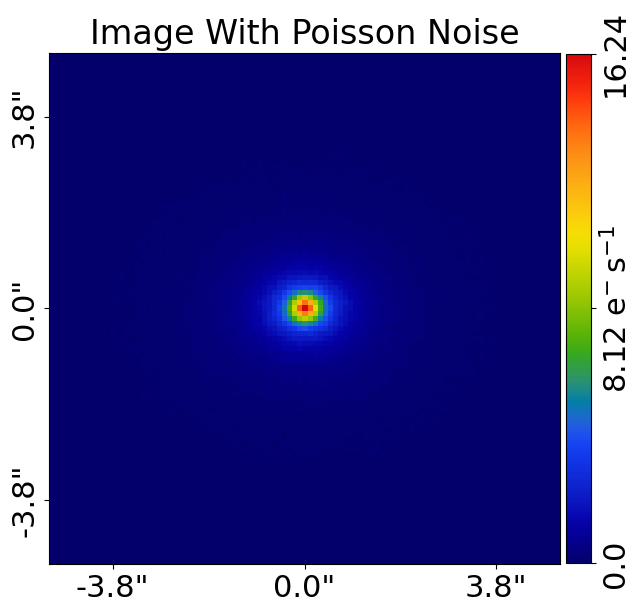

In [11]:
array_plotter = aplt.Array2DPlotter(
    array=ag.Array2D(values=blurred_image_with_poisson_noise, mask=grid.mask),
)
array_plotter.set_title("Image With Poisson Noise")
array_plotter.figure_2d()

It is challenging to see the Poisson noise directly in the image above, as it is often subtle. To make the noise more 
visible, we can subtract the blurred image without Poisson noise from the one with noise.

This subtraction yields the "Poisson noise realization" which highlights the variation in each pixel due to the Poisson 
distribution of photons hitting the CCD. It represents the noise values that were added to each pixel. We call
it the realization because it is one possible outcome of the Poisson process, and the noise will be different each time
we simulate the image.

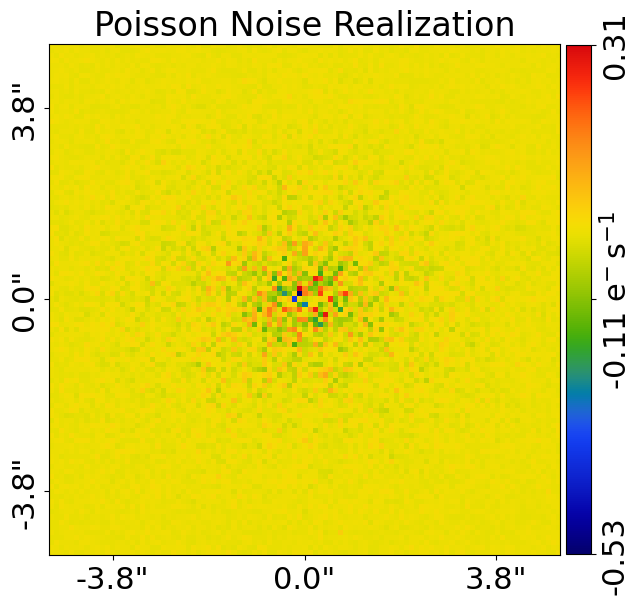

In [12]:
poisson_noise_realization = blurred_image_with_poisson_noise - blurred_image

array_plotter = aplt.Array2DPlotter(
    array=ag.Array2D(values=poisson_noise_realization, mask=grid.mask)
)
array_plotter.set_title("Poisson Noise Realization")
array_plotter.figure_2d()

__Background Sky__

The final effect we will consider when simulating imaging data is the background sky.

In addition to light from the galaxy, the telescope also picks up light from the sky. This background sky light is 
primarily due to two sources: zodiacal light, which is light scattered by interplanetary dust in the solar system, 
and the unresolved emission from distant stars and galaxies.

For our simulation, we'll assume that the background sky has a uniform brightness across the image, measured at 
0.1 electrons per second per pixel. The background sky is added to the image before applying the PSF convolution 
and adding Poisson noise. This is important because it means that the background contributes additional noise to the 
image.

The background sky introduces noise throughout the entire image, including areas where the galaxy is not present. 
This is why CCD images often appear noisy, especially in regions far from where the galaxy signal is detected. 
The sky noise can make it more challenging to observe faint details of the galaxy.

To simulate this, we add a constant background sky to the galaxy image and then apply Poisson noise to create the 
final simulated image as it would appear through a telescope.

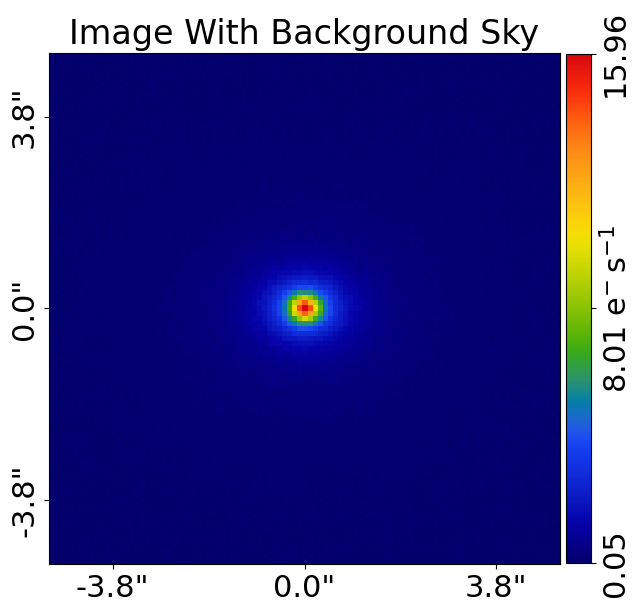

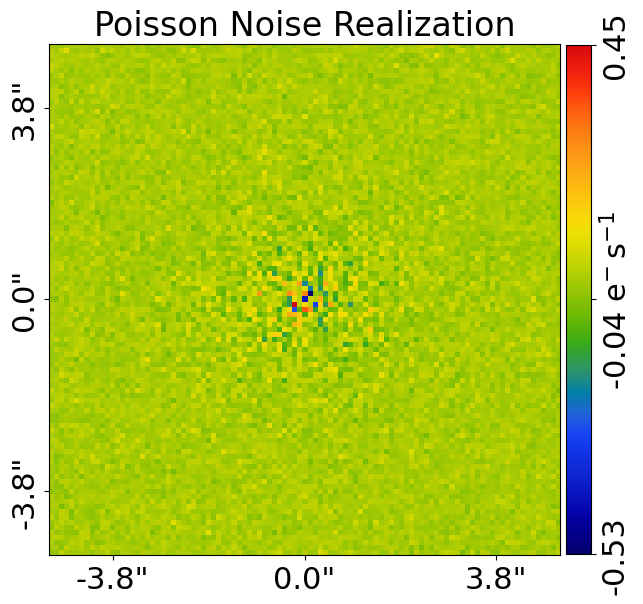

In [13]:
background_sky_level = 0.1

# Add background sky to the blurred galaxy image.
blurred_image_with_sky = blurred_image + background_sky_level
blurred_image_with_sky_counts = blurred_image_with_sky * exposure_time

# Apply Poisson noise to the image with the background sky.
blurred_image_with_sky_poisson_noise = (
    np.random.poisson(
        blurred_image_with_sky_counts, blurred_image_with_sky_counts.shape
    )
    / exposure_time
)

# Visualize the image with background sky and Poisson noise.
array_plotter = aplt.Array2DPlotter(
    array=ag.Array2D(values=blurred_image_with_sky_poisson_noise, mask=grid.mask),
)
array_plotter.set_title("Image With Background Sky")
array_plotter.figure_2d()

# Create a noise map showing the differences between the blurred image with and without noise.
poisson_noise_realization = (
    blurred_image_with_sky_poisson_noise - blurred_image_with_sky
)

array_plotter = aplt.Array2DPlotter(
    array=ag.Array2D(values=poisson_noise_realization, mask=grid.mask)
)
array_plotter.set_title("Poisson Noise Realization")
array_plotter.figure_2d()

__Simulator__

The `SimulatorImaging` object lets us create simulated imaging data while including the effects of PSF blurring, 
Poisson noise, and background sky all at once:

In [14]:
simulator = ag.SimulatorImaging(
    exposure_time=300.0, psf=psf, background_sky_level=0.1, add_poisson_noise=True
)

dataset = simulator.via_galaxies_from(galaxies=galaxies, grid=grid)

By plotting the `data` from the dataset, we can see that it matches the image we simulated earlier. It includes 
the effects of PSF blurring, Poisson noise, and noise from the background sky. This image is a realistic 
approximation of what a telescope like the Hubble Space Telescope would capture.

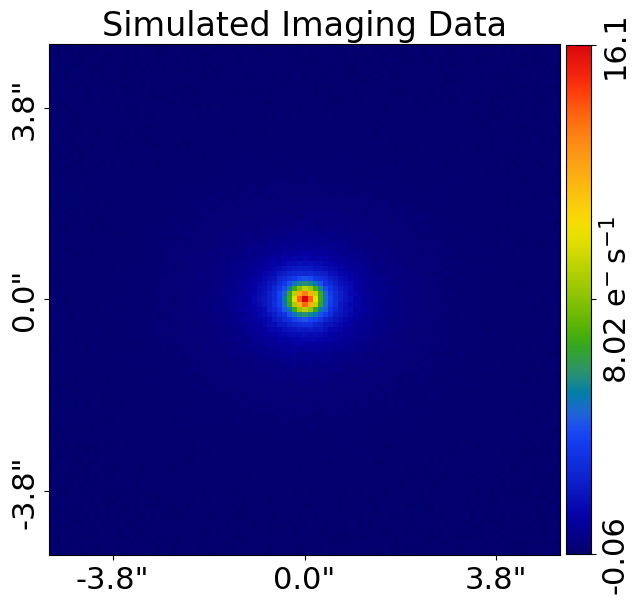

In [15]:
dataset_plotter = aplt.Array2DPlotter(array=dataset.data)
dataset_plotter.set_title("Simulated Imaging Data")
dataset_plotter.figure_2d()

The dataset also includes the `psf` (Point Spread Function) used to blur the galaxy image.

For actual telescope data, the PSF is determined during data processing and is provided along with the observations. 
It's crucial for accurately deconvolving the PSF from the galaxy image, allowing us to recover the true properties 
of the galaxy. We'll explore this further in the next tutorial.

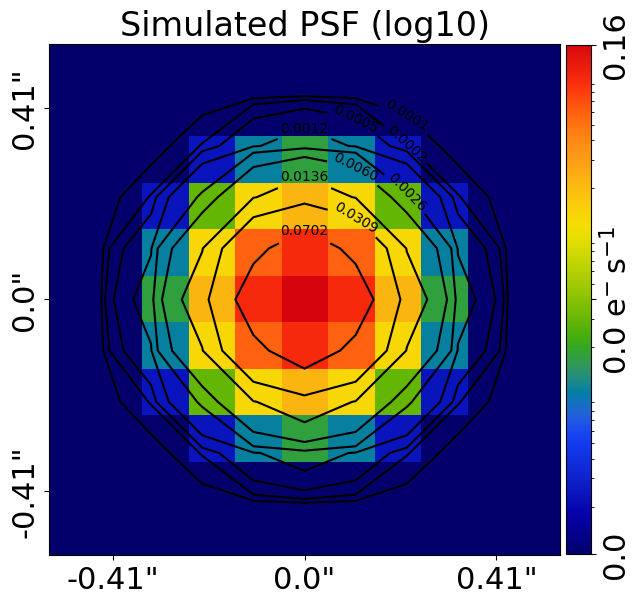

In [16]:
array_plotter = aplt.Array2DPlotter(array=dataset.psf, mat_plot_2d=aplt.MatPlot2D(use_log10=True))
array_plotter.set_title("Simulated PSF")
array_plotter.figure_2d()

The dataset includes a `noise_map`, which represents the Root Mean Square (RMS) standard deviation of the noise 
estimated for each pixel in the image. Higher noise values mean that the measurements in those pixels are 
less certain, so those pixels are given less weight when analyzing the data.

This `noise_map` is different from the Poisson noise arrays we plotted earlier. The Poisson noise arrays show the 
actual noise added to the image due to the random nature of photon-to-electron conversion on the CCD, as calculated 
using the numpy random module. These noise values are theoretical and cannot be directly measured in real telescope data.

In contrast, the `noise_map` is our best estimate of the noise present in the image, derived from the data itself 
and used in the fitting process.

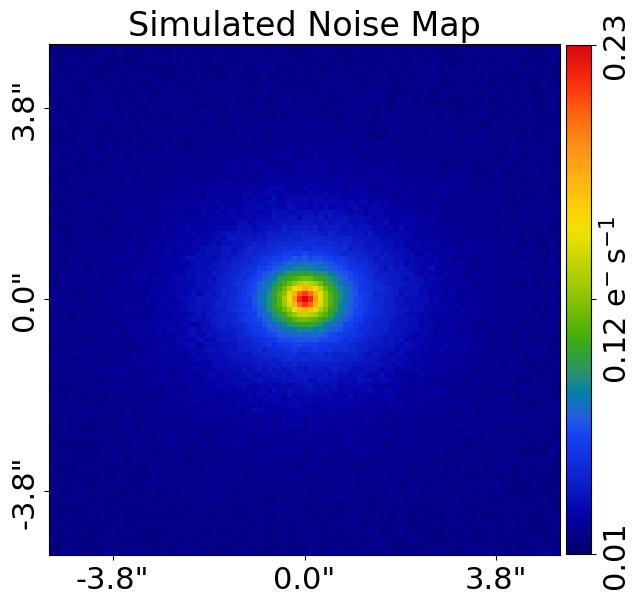

In [17]:
array_plotter = aplt.Array2DPlotter(array=dataset.noise_map)
array_plotter.set_title("Simulated Noise Map")
array_plotter.figure_2d()

The `signal-to-noise_map` shows the ratio of the signal in each pixel to the noise level in that pixel. It is 
calculated by dividing the `data` by the `noise_map`.

This ratio helps us understand how much of the observed signal is reliable compared to the noise, allowing us to 
see where we can trust the detected signal from the galaxy and where the noise is more significant.

In general, a signal-to-noise ratio greater than 3 indicates that the signal is likely real and not overwhelmed by 
noise. For our datasets, the signal-to-noise ratio peaks at ~70, meaning we can trust the signal detected in the
image.

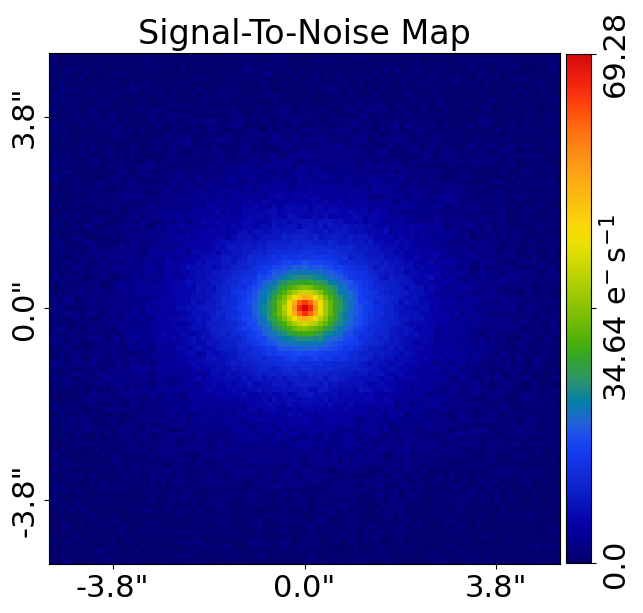

In [18]:
array_plotter = aplt.Array2DPlotter(
    array=dataset.signal_to_noise_map,
)
array_plotter.set_title("Signal-To-Noise Map")
array_plotter.figure_2d()

The `ImagingPlotter` object can display all of these components together, making it a powerful tool for visualizing 
simulated imaging data.

It also shows the Data and PSF on a logarithmic (log10) scale, which helps highlight the faint details in these 
components.

The "Over Sampling" plots on the bottom of the figures display advanced features that can be ignored for now.

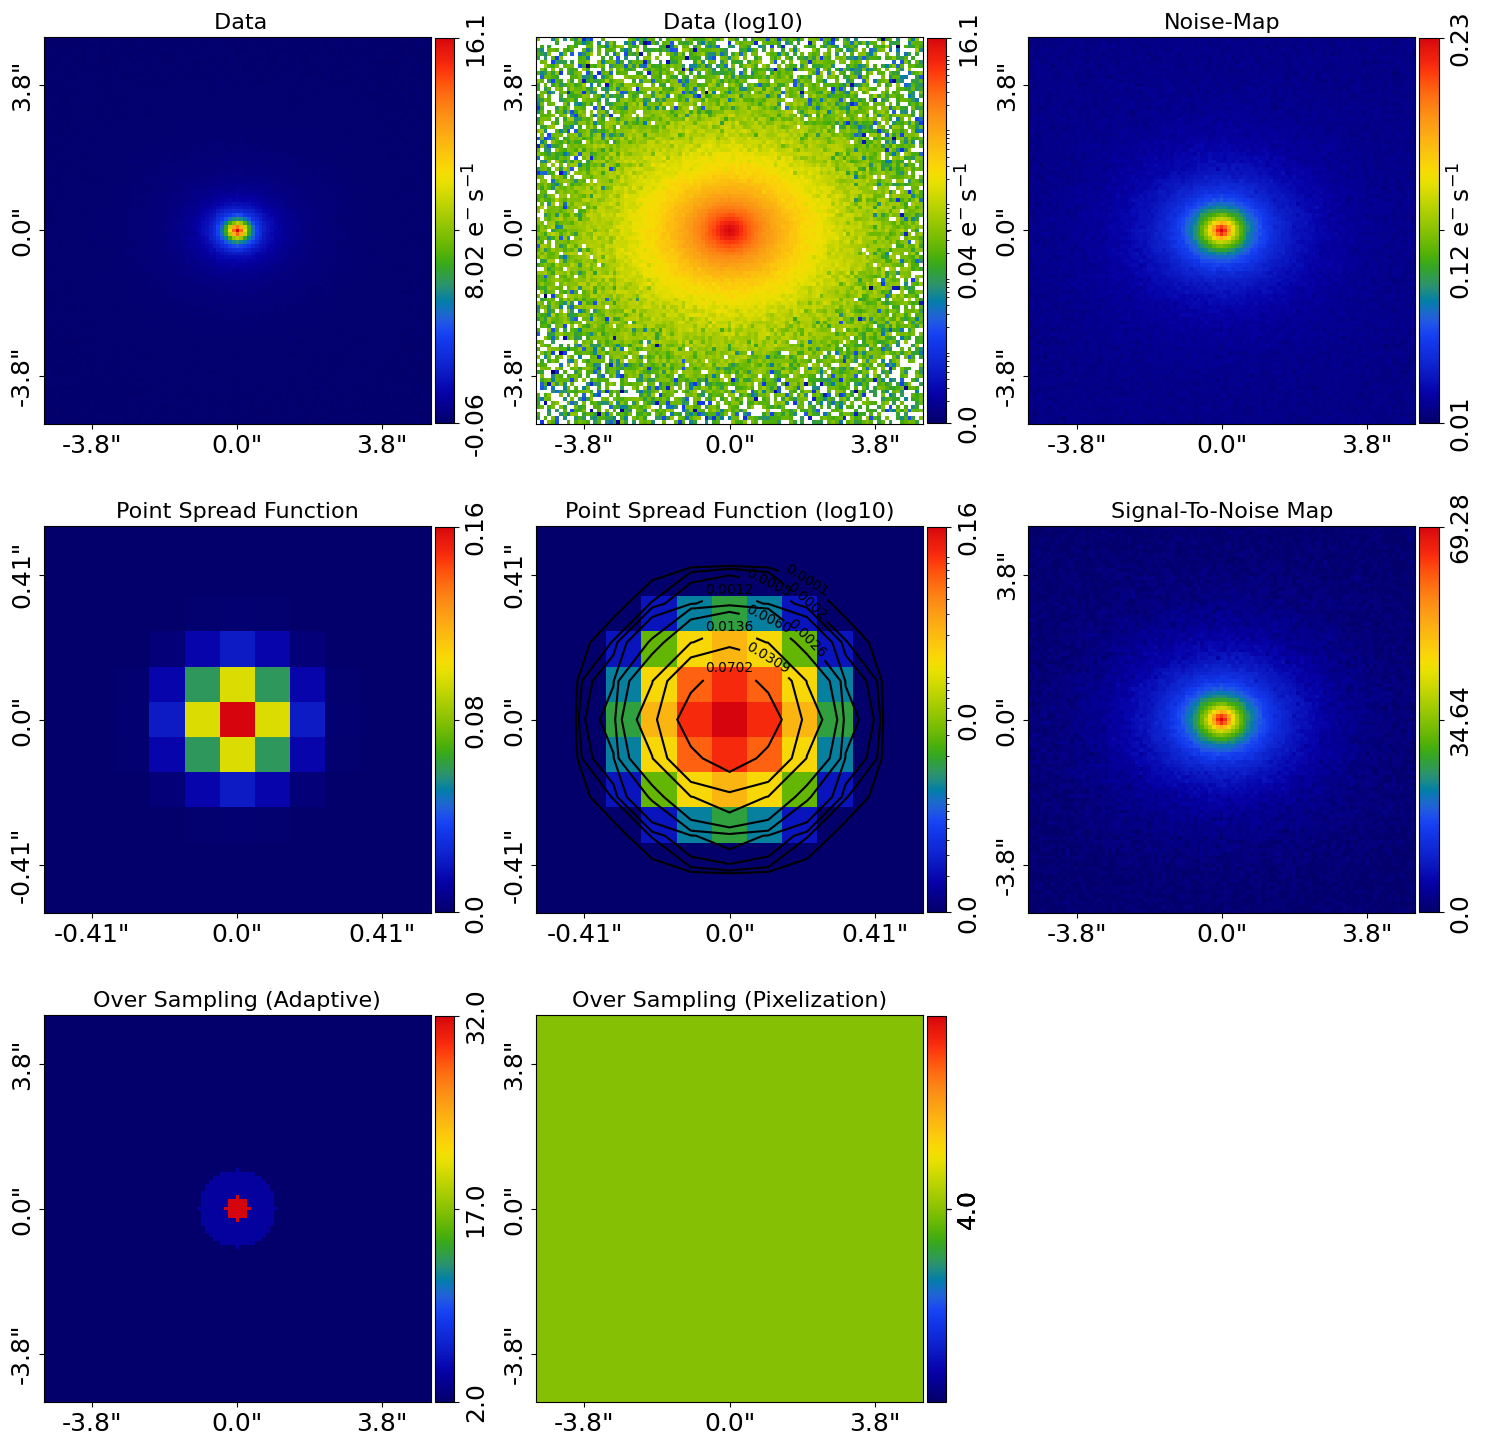

In [19]:
imaging_plotter = aplt.ImagingPlotter(dataset=dataset)
imaging_plotter.set_title(
    None
)  # Disable input title so subplot uses correct title for each sub-figure.
imaging_plotter.subplot_dataset()

__Output__

We will now save these simulated data to `.fits` files, the standard format used by astronomers for storing images.
Most imaging data from telescopes like the Hubble Space Telescope (HST) are stored in this format.

The `dataset_path` specifies where the data will be saved, in this case, in the directory 
`autogalaxy_workspace/dataset/imaging/simple_example/`, which contains many example images distributed with 
the `autogalaxy_workspace`.

The files are named `data.fits`, `noise_map.fits`, and `psf.fits`, and will be used in the next tutorial.

In [20]:
dataset_path = path.join("dataset", "imaging", "simple_example")
print("Dataset Path: ", dataset_path)

dataset.output_to_fits(
    data_path=path.join(dataset_path, "data.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    overwrite=True,
)

Dataset Path:  dataset\imaging\simple_example


__Wrap Up__

In this tutorial, you learned how CCD imaging data of a galaxy is collected using real telescopes like the 
Hubble Space Telescope, and how to simulate this data using the `SimulatorImaging` object.

Let's summarize what we've covered:

- **Optics Blurring**: The optics of a telescope blur the light from galaxies, reducing the clarity and sharpness of 
the images.

- **Poisson Noise**: The process of converting photons to electrons on a CCD introduces Poisson noise, which is random 
variability in the number of electrons collected in each pixel.

- **Background Sky**: Light from the sky is captured along with light from the galaxy, adding a layer of noise across 
the entire image.

- **Simulator**: The `SimulatorImaging` object enables us to simulate realistic imaging data by including all of 
these effects together and contains the `data`, `psf`, and `noise_map` components.

- **Output**: We saved the simulated data to `.fits` files, the standard format used by astronomers for storing images.